In [1]:
1+1

2

In [2]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# !pip install --quiet tensorflow-hub
# !pip install --quiet seaborn

You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0402 02:12:52.829388 139664948762432 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [5]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

In [6]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [7]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

Instructions for updating:
Colocations handled automatically by placer.


W0401 23:26:26.608565 140374037432128 deprecation.py:323] From /home/yulia/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [8]:
type(embed)

tensorflow_hub.module.Module

In [6]:
main_dir = '/home/yulia/'

In [23]:
data_path = main_dir+'final-project/data/raw/hein-daily'

In [24]:
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [25]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1090182100
date 20061114
char_count 278
word_count 49
speakerid 109112991.0
Party R
Congress 109
Chamber S
State TN
Ethnicity W
Age 54.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. FRIST
Full Name FRIST, WILLIAM
match exact
check 1

It took 26.0 seconds to create the dictionary


In [26]:
gender = load_data.create_target_labels(all_speech_ids, descr)[0]
len(gender)

3866201

In [27]:
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 94074 ones and 94074 zeroes
Training speech list size: 188148
Training target list size: 188148
Validation split: 31358 ones and 31358 zeroes
Validation speech list size: 62716
Validation target list size: 62716
Test split: 31358 ones and 31358 zeroes
Test speech list size: 62716
Test target list size: 62716


In [28]:
chunk_len=30

In [16]:
reload(preprocess_data)
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)

Original data has 188148 speeches
It was split into 2541572 chunks
Checks on ids and target 2541572 2541572
Original target mean 0.5
New target mean 0.5144335867722811


In [29]:
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)

Original data has 62716 speeches
It was split into 851633 chunks
Checks on ids and target 851633 851633
Original target mean 0.5
New target mean 0.5181163717235007


In [18]:
train_chunk[:2]

['Mr. Speaker. today I join my colleagues. our fellow Americans. and people around the world to offer our prayers to the families of those lost or injured in yesterdays unspeakable',
 'crimes. We stand here in solidarity with the President. who represents this Nation and its resolve to hunt down those responsible and bring them to justice. No one should doubt']

In [19]:
del descr

In [20]:
len(train_chunk)

2541572

In [25]:
batches = list(range(0, len(train_chunk), int(len(train_chunk)/10)))

In [ ]:
batches

In [21]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

start_time = time.time()
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    train_emb = session.run(embed(train_chunk[:254157]))
print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))


It took 327.2 seconds to create embeddings


In [60]:
start_time = time.time()
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    train_emb2 = session.run(embed(train_chunk[2287413:]))
print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))


It took 336.9 seconds to create embeddings


In [61]:
train_emb = np.concatenate((train_emb, train_emb2), axis=0)

In [62]:
train_emb.shape

(2541572, 512)

In [7]:
outdata_path = main_dir+'final-project/Classification/data'

In [123]:
with open(os.path.join(outdata_path, 'train_target_chunk'), 'wb') as fp:
    pickle.dump(train_target_chunk, fp)
with open(os.path.join(outdata_path, 'val_target_chunk'), 'wb') as fp:
    pickle.dump(val_target_chunk, fp)

In [39]:
with open(os.path.join(outdata_path, 'val_ids_chunk'), 'wb') as fp:
    pickle.dump(val_ids_chunk, fp)

In [8]:
with open(os.path.join(outdata_path, 'train_target_chunk'), 'rb') as fp:
    train_target_chunk = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target_chunk'), 'rb') as fp:
    val_target_chunk = pickle.load(fp)

In [65]:
with open(os.path.join(outdata_path, 'train_emb30'), 'wb') as fp:
    pickle.dump(train_emb[:1524942], fp)
with open(os.path.join(outdata_path, 'train_emb30_p2'), 'wb') as fp:
    pickle.dump(train_emb[1524942:], fp)

In [9]:
with open(os.path.join(outdata_path, 'train_emb30'), 'rb') as fp:
    train_emb = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_emb30_p2'), 'rb') as fp:
    train_emb2 = pickle.load(fp)

In [11]:
train_emb = np.concatenate((train_emb, train_emb2), axis=0)
train_emb.shape

(2541572, 512)

In [98]:
batches = list(range(0, len(val_chunk), int(len(val_chunk)/3)))
batches

[0, 283877, 567754, 851631]

In [99]:
val_emb = np.empty([0,512])
for i in range(len(batches)):
    if i < len(batches) - 1:
        start_time = time.time()
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            val_emb2 = session.run(embed(val_chunk[batches[i]:batches[i+1]]))
        print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))
    if i == len(batches) - 1:
        start_time = time.time()
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            val_emb2 = session.run(embed(val_chunk[batches[i]:]))
        print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))      
    val_emb = np.concatenate((val_emb, val_emb2), axis=0)


It took 410.9 seconds to create embeddings

It took 413.8 seconds to create embeddings

It took 410.3 seconds to create embeddings

It took 52.2 seconds to create embeddings


In [103]:
del train_emb2, val_emb2, train, val, test, all_speech_ids, all_speeches, train_chunk, val_chunk

In [122]:
gc.collect()

77

In [110]:
with open(os.path.join(outdata_path, 'val_emb30'), 'wb') as fp:
    pickle.dump(val_emb[:283877], fp)
with open(os.path.join(outdata_path, 'val_emb30_p2'), 'wb') as fp:
    pickle.dump(val_emb[283877:567754], fp)
with open(os.path.join(outdata_path, 'val_emb30_p3'), 'wb') as fp:
    pickle.dump(val_emb[567754:], fp)

In [12]:
with open(os.path.join(outdata_path, 'val_emb30'), 'rb') as fp:
    val_emb = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_emb30_p2'), 'rb') as fp:
    val_emb2 = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_emb30_p3'), 'rb') as fp:
    val_emb3 = pickle.load(fp)

In [13]:
val_emb = np.concatenate((val_emb, val_emb2, val_emb3), axis=0)
val_emb.shape

(851633, 512)

In [14]:
del train_emb2, val_emb2, val_emb3

In [15]:
gc.collect()

7

In [16]:
logs_base_dir = main_dir+"final-project/Classification/logs"

In [42]:
mlp_model_params = {
    'model': 'mlp',
    'learning_rate': 0.001,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 128,
    'dropout_rate': 0.2
}

In [43]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_emb, train_target_chunk), (val_emb, val_target_chunk)), logs_base_dir, **mlp_model_params)

Train on 2541572 samples, validate on 851633 samples
Epoch 1/1000
 - 90s - loss: 0.6555 - acc: 0.6092 - val_loss: 0.6494 - val_acc: 0.6177
Epoch 2/1000
 - 92s - loss: 0.6521 - acc: 0.6139 - val_loss: 0.6478 - val_acc: 0.6197
Epoch 3/1000
 - 87s - loss: 0.6509 - acc: 0.6157 - val_loss: 0.6471 - val_acc: 0.6210
Epoch 4/1000
 - 87s - loss: 0.6502 - acc: 0.6170 - val_loss: 0.6462 - val_acc: 0.6218
Epoch 5/1000
 - 87s - loss: 0.6495 - acc: 0.6180 - val_loss: 0.6474 - val_acc: 0.6215
Epoch 6/1000
 - 91s - loss: 0.6491 - acc: 0.6185 - val_loss: 0.6477 - val_acc: 0.6204
Validation accuracy: 0.6204374432563782, loss: 0.647665315880699


In [44]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target_chunk)

528385

In [45]:
probs_dir = main_dir+"final-project/Classification/data/ngram/gender"

In [46]:
with open(os.path.join(probs_dir, 'val_pred_probs_chunk'), 'wb') as fp:
    pickle.dump(val_pred_probs, fp)

In [47]:
pred_df = pd.DataFrame({'ids': val_ids_chunk, 'target': val_target_chunk, 'probs': val_pred_probs.flatten(), 'preds': val_preds.flatten()})

In [48]:
f = {'probs': [min, max, 'mean']}
pred_aggr_df = pred_df.groupby('ids').agg(f).reset_index()
pred_aggr_df.columns = ['ids', 'probs_min', 'probs_max', 'probs_mean']
pred_aggr_df = pred_aggr_df.merge(pred_df[['target', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df = pred_aggr_df.merge(pred_df[['preds', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df['preds_probs_mean'] = pred_aggr_df['probs_mean'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df['preds_mean'] = pred_aggr_df['preds'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df.head()

,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1000000354,0.259575,0.599006,0.415242,0,0.200000,0,0
1,1000000454,0.322106,0.332433,0.327270,0,0.000000,0,0
2,1000000541,0.235235,0.664148,0.402826,0,0.155556,0,0
3,1000000727,0.322267,0.583716,0.498080,0,0.636364,0,1
4,1000000738,0.319887,0.563076,0.477984,0,0.454545,0,0


In [49]:
np.mean(val_target_chunk == val_preds.flatten())

0.62043744194976

In [50]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_probs_mean)

0.6727310415205051

In [51]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_mean)

0.6633713884814083

Confusion matrix, without normalization
[[23471  7887]
 [12638 18720]]
             precision    recall  f1-score   support

       Male       0.65      0.75      0.70     31358
     Female       0.70      0.60      0.65     31358

avg / total       0.68      0.67      0.67     62716



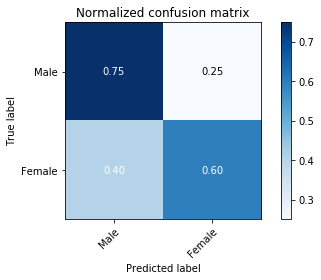

In [52]:
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(pred_aggr_df.target, pred_aggr_df.preds_probs_mean, classes, normalize=True)

Confusion matrix, without normalization
[[23971  7387]
 [13725 17633]]
             precision    recall  f1-score   support

       Male       0.64      0.76      0.69     31358
     Female       0.70      0.56      0.63     31358

avg / total       0.67      0.66      0.66     62716



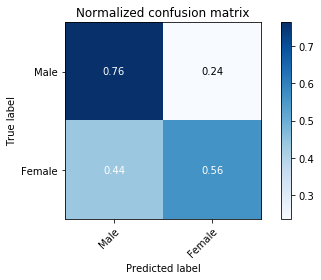

In [53]:
explore_data.plot_confusion_matrix(pred_aggr_df.target, pred_aggr_df.preds_mean, classes, normalize=True)